1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [140]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product

In [2]:
%load_ext autoreload
%autoreload 2

In [189]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [190]:
working = '../data/working'

In [463]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [464]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

In [465]:
targets['eos']['box'] = targets['eos']['box'][5:6]
targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
targets['eos']['temp'] = targets['eos']['temp'][5:6]
targets['eos']['beta'] = targets['eos']['beta'][5:6]
targets['eos']['energy'] = targets['eos']['energy'][5:6]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [466]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [467]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

(3, 3)

In [468]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [469]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [470]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    print('c',C)
    

    return D, C

In [471]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    print('shapes', C.shape, D.shape)
    print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [472]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [473]:
low_knots = list(np.linspace(1.05, 1.25, 3))
coeffs_low = [u_core(r+0.2)/(6*0.1**3) for r in low_knots]
#coeffs_low = [0.0, 0.0, 0.0]
coeffs_low

[17113.755717924174, 11468.628163754847, 7820.796633088171]

## Minimizing statistical distance

1. Start from previously optimized parameters beta and lambda
2. Include additional b-splines basis functions 
3. Include additional constraints on beta at the short range
4. Set up Newton optimizer (as a function)

In [474]:
def make_sd_matrices(target, stats, keytrj=None):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            # add energy
            y.append(energy)
            beta.append(bb)
            weights.append(w)
            
            # create an array of independent variables
            x_vars = [config[0][0], config[1][0]] # embedding

            #print('config[2]', config[2])
            x_vars += list(0.5*config[2])                   # pair interaction b-spline stats
            X.append(x_vars)
            
        bounds.append([lo_bound, len(y)])

    return np.array(X), np.array(y), np.array(weights), np.array(beta), bounds


1. Add penalty to N-R
2. Take care of short distance repulsion
3. Modify inspect notebook to see the results
4. Convert to Yuri's format (inversion of the transformation matrix to TPF basis?)

In [475]:
scale = np.logspace(pair_knots[0], pair_knots[-1], len(pair_knots))
scale = np.sqrt(np.logspace(-6, -3, len(pair_knots)))
[(s, k) for s, k in zip(scale, pair_knots)]

[(0.001, 1.05),
 (0.0010857111194022039, 1.1500000000000001),
 (0.0011787686347935879, 1.25),
 (0.001279802213997954, 1.35),
 (0.0013894954943731374, 1.4500000000000002),
 (0.0015085907086001779, 1.55),
 (0.0016378937069540646, 1.6500000000000001),
 (0.0017782794100389228, 1.75),
 (0.0019306977288832496, 1.85),
 (0.002096179992453126, 1.9500000000000002),
 (0.0022758459260747888, 2.05),
 (0.0024709112279856045, 2.1500000000000004),
 (0.0026826957952797246, 2.25),
 (0.0029126326549087384, 2.35),
 (0.0031622776601683794, 2.45),
 (0.0034333200182819932, 2.55),
 (0.0037275937203149383, 2.6500000000000004),
 (0.004047089950759761, 2.75),
 (0.004393970560760791, 2.85),
 (0.004770582696143928, 2.95),
 (0.005179474679231213, 3.05),
 (0.005623413251903491, 3.1500000000000004),
 (0.006105402296585327, 3.25),
 (0.006628703161826441, 3.3500000000000005),
 (0.0071968567300115215, 3.45),
 (0.007813707376518092, 3.55),
 (0.008483428982440717, 3.6500000000000004),
 (0.00921055317689482, 3.75),
 (0.01,

In [476]:
# 3rd order penalty for larger distances

partitions = []
partitions.append([2, None, None, None, None]) # Embedding function - no penalty
#partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(pair_knots), 3, None, [], []])
Dp3, Cp3, c3 = penalty_matrix(partitions)
c3, Cp3, Dp3[:]

((2,), (2, 2))
('c', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]))
((43,), (43, 43))
('shapes', (45,), (45, 45))
('C', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
('shapes2', (45,), (45, 45), ())


(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   1., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,  19., -12.,   3.],
        [  0.,   0.,   0., ..., -12.,  10.,  -3.],
        [  0.,   0.,   0., ...,   3.,  -3.,   1.]]))

In [477]:
# 2nd order penalty for larger distances
partitions = []
partitions.append([2+27, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots)-27, 3, None, [], []])
Dp2, Cp2, c2 = penalty_matrix(partitions)
c2, Cp2, Dp2[:]

((29,), (29, 29))
('c', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
((16,), (16, 16))
('shapes', (45,), (45, 45))
('C', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
('shapes2', (45,), (45, 45), ())


(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,  19., -12.,   3.],
        [  0.,   0.,   0., ..., -12.,  10.,  -3.],
        [  0.,   0.,   0., ...,   3.,  -3.,   1.]]))

In [478]:
Dp3.shape, Dp2.shape

((45, 45), (45, 45))

In [479]:
tkeys = ['bcc_npt_langevin_300K',
'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [492]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.1
targets['eos']['weight'] = 1.0
targets['eos_bcc']['weight'] = 5.0
targets['relax']['weight'] = 2000.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('eos', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('inf', 0.0),
 ('relax', 2000.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('eos_bcc', 5.0),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('bain', 0.1)]

('rss', 4487.285344418309, 12.8, 1.0)
('rss', 4204.546476512634, 12.8, 1.0)
('rss', 4045.967171275478, 12.8, 1.0)
('rss', 3964.607939877031, 12.8, 1.0)
('rss', 3924.9835210779875, 12.8, 1.0)
('rss', 3903.1730782647014, 12.8, 1.0)
('rss', 3885.608510079888, 12.8, 1.0)
('rss', 3862.1135032858533, 12.8, 1.0)
('rss', 3833.809386896659, 12.8, 1.0)
('rss', 3809.5334946369967, 12.8, 1.0)
('rss', 3793.0904183096322, 12.8, 1.0)
('rss', 3779.446562457988, 12.8, 1.0)
('rss', 3765.655956890154, 12.8, 1.0)
('rss', 3749.7851344839833, 12.8, 1.0)
('rss', 3729.249123922641, 12.8, 1.0)
('rss', 3710.985640667724, 12.8, 1.0)


(1.0, 5.65)

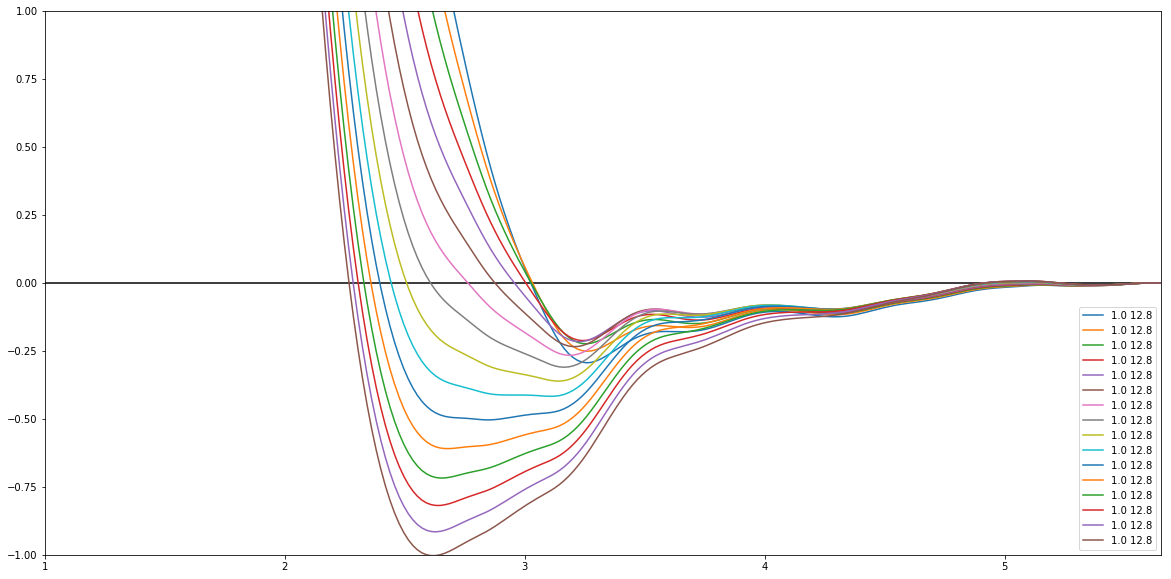

In [493]:
plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[:]):
#     if i != 1:
#         continue
    #for lamb in list(np.logspace(-3, np.log10(2.774), 4)):
    for lamb3, lamb2 in product([1.0], [12.8]):#, 1e-4, 1e-3]):
        X, y, weight, bbb, bounds = make_sd_matrices(targets, stat)
        #print(weight)
        
        ww = np.diag(weight)
        
        b = np.linalg.inv(X.T.dot(ww).dot(X) + 0.5*lamb3*Dp3 + 0.5*lamb2*Dp2).dot(X.T.dot(ww).dot(y))# - 0.5*lamb3*Cp)
        #b = np.linalg.inv(X.T.dot(ww).dot(X)).dot(X.T.dot(ww).dot(y))

        rss = (y - X.dot(b)).T.dot(ww).dot(y - X.dot(b))

        print('rss', rss, lamb2, lamb3)
        label_str = str(round(stat['hyperparams']['edens'][0], 2))
        label_str += '; embed: ' + str(b[:2])
        label_str += '; lambda: ' + str(round(lamb3, 4))
        label_str += '; RSS: ' + str(round(rss, 0))
        
        hat = X.dot(np.linalg.inv(X.T.dot(X) + 0.5*lamb3*Dp3 + 0.5*lamb2*Dp2)).dot(X.T)

        hat_trace = np.trace(hat)
        gcv = (y - X.dot(b)).T.dot(y - X.dot(b))/(X.shape[0] - hat_trace)
        label_str += '; GCV: ' + str(gcv)#str(round(gcv, 0))
        
        vec = (y - X.dot(b))/(1. - np.diag(hat))
        cv = vec.T.dot(vec)
        
        label_str += '; CV: ' + str(cv)#str(round(gcv, 0))
    
        rr = np.linspace(0.95, 5.7, 250)

        coeffs = coeffs_low[-1:] + list(b[2:])

        knots = [1.05, 1.15, 1.25][-1:] + pair_knots +[5.35, 5.45, 5.55, 5.65]

        bs = [make_bspline(coeffs, knots, r) for r in rr]
        label_str = str(lamb3) + ' ' + str(lamb2)
        plt.plot(rr, bs, label=label_str)
    
        betas.append(b)

plt.hlines(0,1,6)
plt.legend(loc='lower right')
#plt.ylim(-100,2000)
plt.ylim(-1.0,1)
plt.xlim(1.0,5.65)

In [494]:
def newton_raphson_weighted(X, y, beta, b_init, lamb3 = 0.0, lamb2=0.0, weights=None, tol=1e-4, itmax=10000):
    
    b_old = copy.copy(b_init)
    loss_old = 0.0
    
    if weights is not None:
        assert len(weights) == len(y), "Wrong weight list"
        ww = np.diag(weights)
    else:
        ww = np.identity(len(y))
    
    itcount = 0
    while True:

        # Jacobian (gradient of the loss function)
        
        P = np.exp(-0.5*beta*(X.dot(b_old) - y))
        P2 = P**2

        #J = X.T.dot(P-P2) + lamb*Dsqr.dot(b_old)
        
        # Inverse Hessian
        W = np.diag(0.5*P - P2) # weight matrix
        W = ww.dot(W)
        H = X.T.dot(W).dot(X) - lamb3*Dp3 - lamb2*Dp2
        Hi = np.linalg.inv(H)

        # N-R update
        #b_new = b_old - Hi.dot(J)#dot(X.T).dot(P - P2)
        #b_new = Hi.dot(X.T).dot(W).dot(X.dot(b_old) + Wi.dot(P - P2))
        
        b_new = Hi.dot(X.T).dot(W.dot(X).dot(b_old) + ww.dot(P - P2))

        
        # Loss from the previous step
        loss = np.arccos(1. - (1 - P).T.dot(ww).dot(1 - P)/(2.0*np.sum(ww)))**2
        loss_full = loss + 0.5*lamb3*b_old.T.dot(Dp3).dot(b_old)
        loss_full = loss_full + 0.5*lamb2*b_old.T.dot(Dp2).dot(b_old)
        loss_reg = b_old.T.dot(Dp3).dot(b_old)
        loss_reg2 = b_old.T.dot(Dp2).dot(b_old)

        df = abs((loss-loss_old)/loss)
        
        if itcount % 100 == 0:
            print(itcount, loss, loss_reg, loss_reg2, loss_full, np.sum(abs(b_new - b_old)), df, X.dot(b_new)[-6])
#            print('emb', b_new[:2], X[-6,:2], X.dot(b_new)[-6])
#             print('pair', b_new[2:], X[-6,2:])
#             print('ee', X[-6,:2].dot(b_new[:2]), X[-6,2:].dot(b_new[2:]))

        #print(np.sum(abs(b_new - b_old)), abs(df))
        if (np.sum(abs(b_new - b_old)) < tol) or itcount > itmax or abs(df) < 1e-6:
            break
            
        itcount += 1
        b_old = b_new
        loss_old = loss
    
    return b_new, loss

In [495]:
betas[-1]

array([-4.49779872e-01,  1.09664665e-04,  4.22824426e+03,  3.54009480e+03,
        2.91119261e+03,  2.34153772e+03,  1.83113026e+03,  1.37997039e+03,
        9.88058321e+02,  6.55394274e+02,  3.81978459e+02,  1.67811053e+02,
        1.24862009e+01, -8.79627304e+01, -1.43545176e+02, -1.67016514e+02,
       -1.68316234e+02, -1.58859588e+02, -1.52245978e+02, -1.41522891e+02,
       -1.31799084e+02, -1.24427156e+02, -1.07866113e+02, -8.29740112e+01,
       -6.06836589e+01, -4.81849563e+01, -4.36744378e+01, -3.91472388e+01,
       -3.22134949e+01, -2.58537638e+01, -2.26912671e+01, -2.12961404e+01,
       -2.06873517e+01, -1.86526528e+01, -1.45559864e+01, -1.10689543e+01,
       -8.78888460e+00, -5.32464713e+00, -1.32322585e+00,  9.00599115e-01,
        1.19455876e+00,  1.38108240e+00, -4.40635093e-01, -1.37195754e+00,
       -1.22719835e+00])

In [496]:
b_init = betas[-1]

# b_init = np.array([-4.41638459e-01,  1.12809967e-04,  3.62909040e+03,  3.04860868e+03,
#         2.51685319e+03,  2.03382451e+03,  1.59952447e+03,  1.21395550e+03,
#         8.77120108e+02,  5.89020216e+02,  3.49656610e+02,  1.59028325e+02,
#         1.69043690e+01, -7.89862164e+01, -1.34805595e+02, -1.59862247e+02,
#        -1.63547312e+02, -1.56107044e+02, -1.49747979e+02, -1.40705813e+02,
#        -1.32630325e+02, -1.25865305e+02, -1.11342301e+02, -8.81522330e+01,
#        -6.55198793e+01, -5.10043776e+01, -4.41496602e+01, -3.91772077e+01,
#        -3.31573579e+01, -2.73413842e+01, -2.42247069e+01, -2.40317554e+01,
#        -2.52260279e+01, -2.41380865e+01, -1.94495164e+01, -1.54200675e+01,
#        -1.35433675e+01, -9.66540540e+00, -4.72526004e+00, -2.02888414e+00,
#        -1.53765244e+00, -3.19644049e-01, -1.90337793e+00, -1.66864634e+00,
#        -1.36903049e+00])
#b_init = b_all

In [383]:
lamb3 = 4e-4
lamb2 = 2e-3
# lamb3 = 1.0

for i, stat in enumerate(stats_list[-1:]):

    X, y, weight, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

    print(X.shape, y.shape, beta.shape, b_init.shape, weight.shape)

    #b_final, loss_final = newton_raphson_penalized(X, y, beta, b_init, lamb=1e-4, weights=None, itmax=1e5)
    b_final, loss_final = newton_raphson_weighted(X, y, beta, b_init, lamb3=lamb3, lamb2=lamb2, weights=weight, itmax=1e5)

((1411, 45), (1411,), (1411,), (45,), (1411,))
(0, 1.3736309612298268e-06, 885.4305040059262, 27.501543158868373, 0.20458901759101486, 73.8976083383277, 1.0, -1138.4121063829075)
(100, 1.0040159822023231e-06, 949.3619773232149, 97.87112132371954, 0.28774452080434476, 3.2446795101047647, 0.0024676958685917634, -1138.4962901641022)
(200, 8.221241380247991e-07, 1094.7475358547163, 133.21647110346083, 0.3521668003985421, 3.7075763518758658, 0.0016144385743964082, -1138.5424167386227)
(300, 7.199257209301276e-07, 1214.3886107608414, 149.85285242469791, 0.39273129450258715, 8.26245433596026, 0.0010873947366053056, -1138.5704141947983)
(400, 6.576699627843596e-07, 1305.4082405263298, 157.32240289962806, 0.4184047086748568, 3.656049637083794, 0.0007497034297957062, -1138.5895227056972)
(500, 6.175200897548044e-07, 1372.6765540814004, 160.3385351835588, 0.43487446351992864, 20.40878503960016, 0.0005278747806917642, -1138.6036982575301)
(600, 5.904732102938323e-07, 1421.9435938060751, 161.137382

(5400, 4.950173744165573e-07, 1606.3219986971244, 146.31868754897096, 0.46758358230577024, 4.887950912817947, 2.52180011536006e-06, -1138.701710239152)
(5500, 4.948977329987958e-07, 1606.4127398009778, 146.30383032637621, 0.4675868731843048, 3.637628447048818, 2.359543388034834e-06, -1138.701875271868)
(5600, 4.947831348805644e-07, 1606.5098779646542, 146.28985558477996, 0.4675923259608457, 4.140610329177962, 2.25956504820666e-06, -1138.7020517001536)
(5700, 4.946745777083547e-07, 1606.598228545221, 146.27653480365518, 0.4675966751872771, 6.097353685226243, 1.9916365983992394e-06, -1138.7021950318822)
(5800, 4.945708040434651e-07, 1606.6903321087093, 146.26389784637905, 0.467602458838925, 13.30815850208342, 2.03964470818393e-06, -1138.7023358755741)
(5900, 4.944715387726073e-07, 1606.759901321475, 146.2521853664316, 0.4676046601022654, 6.0713795006955396, 1.972246951995882e-06, -1138.702486571057)
(6000, 4.943770974211906e-07, 1606.8333430370312, 146.24075227426908, 0.46760791525877277

In [497]:
b_all = b_final
b_all = b_init
b_all

array([-4.49779872e-01,  1.09664665e-04,  4.22824426e+03,  3.54009480e+03,
        2.91119261e+03,  2.34153772e+03,  1.83113026e+03,  1.37997039e+03,
        9.88058321e+02,  6.55394274e+02,  3.81978459e+02,  1.67811053e+02,
        1.24862009e+01, -8.79627304e+01, -1.43545176e+02, -1.67016514e+02,
       -1.68316234e+02, -1.58859588e+02, -1.52245978e+02, -1.41522891e+02,
       -1.31799084e+02, -1.24427156e+02, -1.07866113e+02, -8.29740112e+01,
       -6.06836589e+01, -4.81849563e+01, -4.36744378e+01, -3.91472388e+01,
       -3.22134949e+01, -2.58537638e+01, -2.26912671e+01, -2.12961404e+01,
       -2.06873517e+01, -1.86526528e+01, -1.45559864e+01, -1.10689543e+01,
       -8.78888460e+00, -5.32464713e+00, -1.32322585e+00,  9.00599115e-01,
        1.19455876e+00,  1.38108240e+00, -4.40635093e-01, -1.37195754e+00,
       -1.22719835e+00])

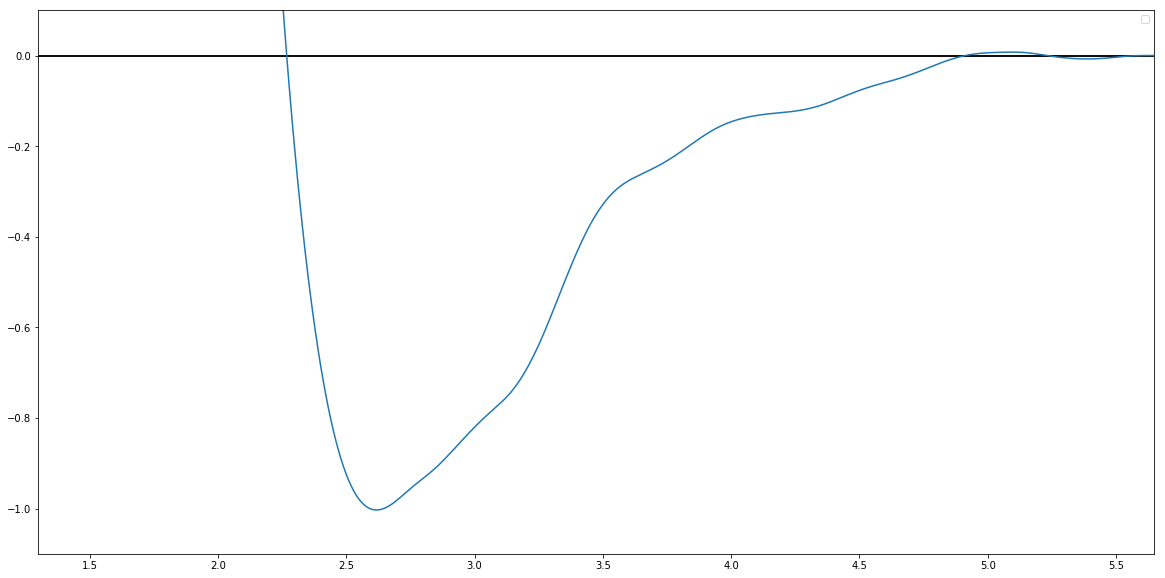

In [498]:
plt.figure(figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
plt.plot(np.array(b_all[2:])*(6*0.1**3) , 'y')
plt.ylim(-1.2,1)
plt.hlines(0, 0, 42)
plt.legend()


rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])

In [499]:
bounds

[[0, 146],
 [146, 147],
 [147, 383],
 [383, 389],
 [389, 588],
 [588, 788],
 [788, 791],
 [791, 913],
 [913, 1039],
 [1039, 1172],
 [1172, 1263],
 [1263, 1399],
 [1399, 1411]]

[-1138.975, 0.0, -1136.448, -1136.66, -1190.373, -1127.339]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


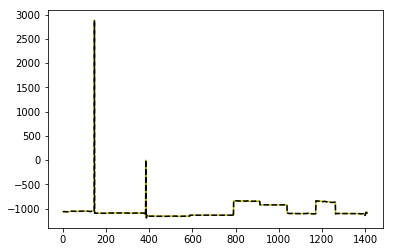

In [500]:
plt.plot(X.dot(b_all), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
# plt.xlim(len(X)-7,len(X)-1)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in X.dot(b_all)[bounds[3][0]:bounds[3][1]]])
print([round(z, 3) for z in y[bounds[3][0]:bounds[3][1]]])

#print([round(z, 3) for z in y[-6:]])

In [501]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [502]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weights, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

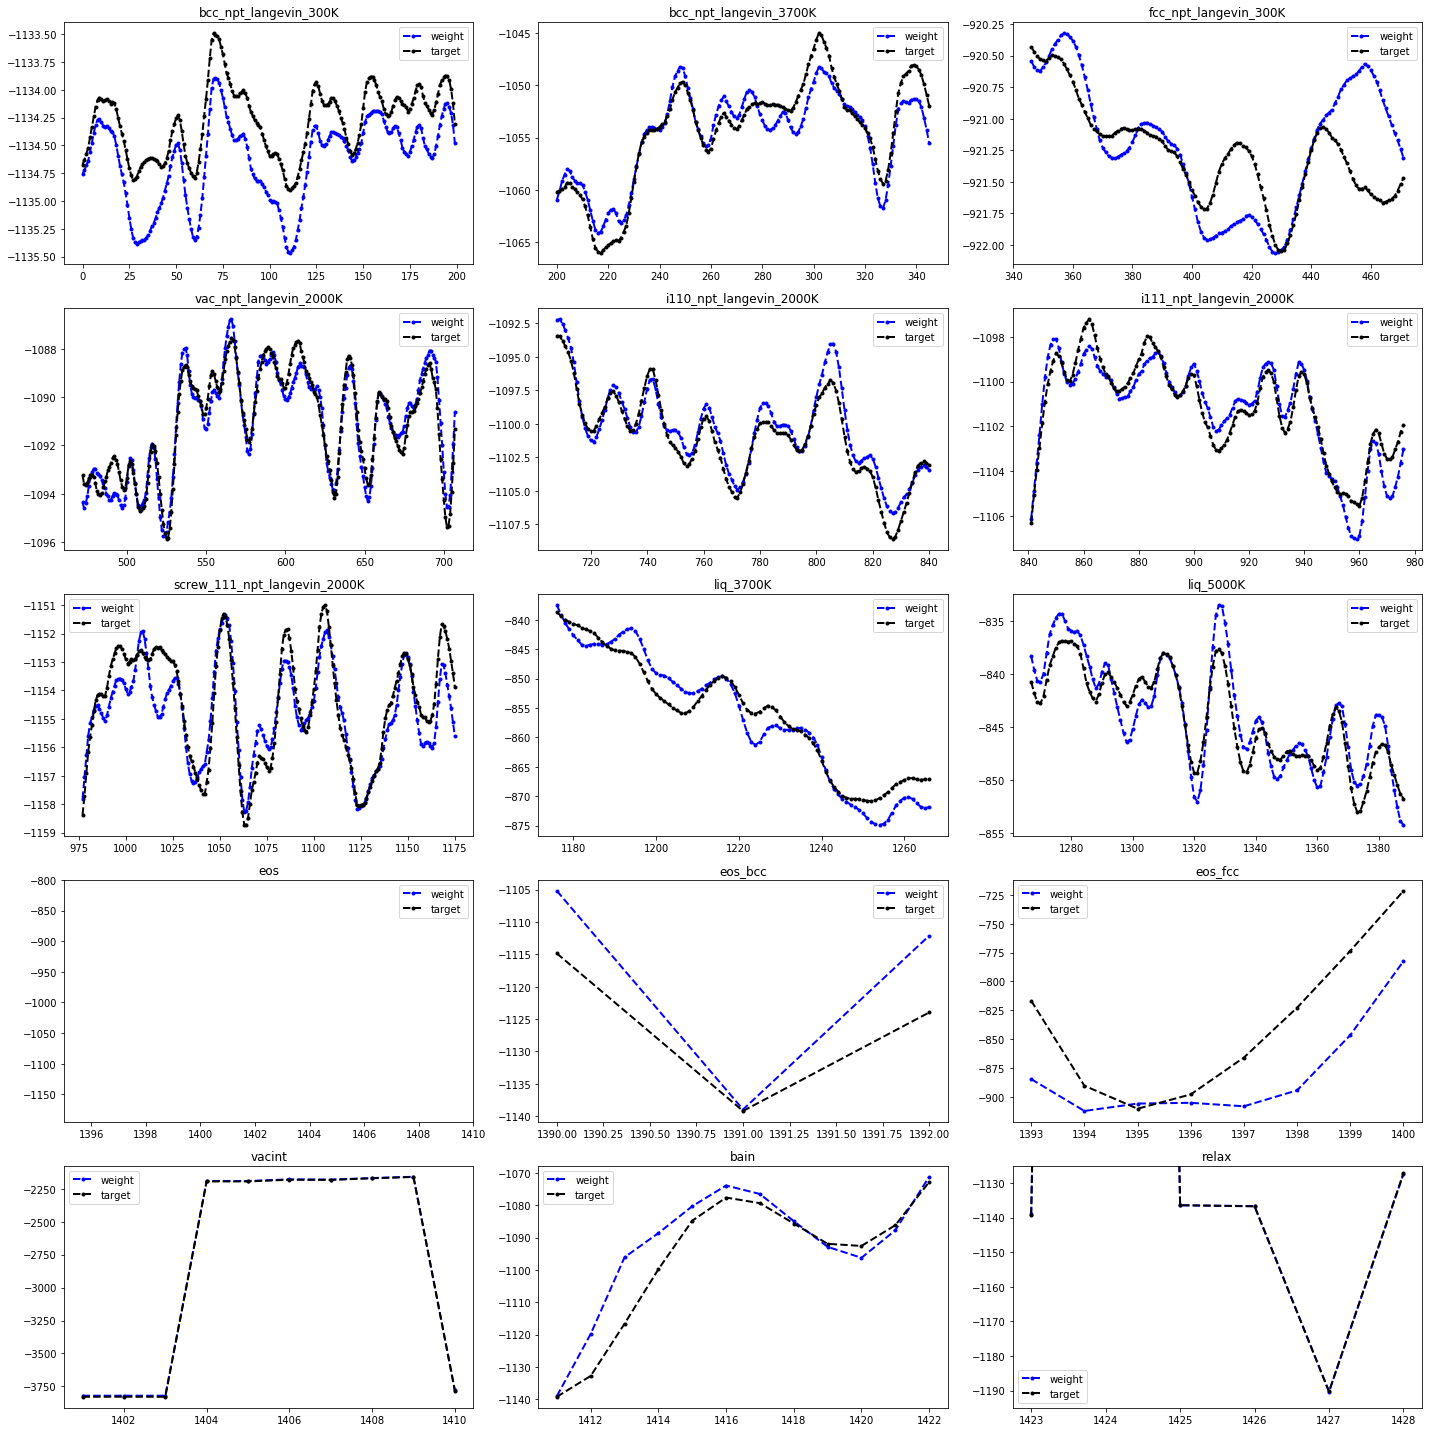

In [503]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xallx.dot(b_all)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
    if trj == 'eos':
        axes[i,j].set_ylim(-1195, -800)
        axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [434]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [435]:
len(stats_tpf['relax']['energy'][0][2]), len(stats_bspline['relax']['energy'][0][2])

(50, 46)

In [436]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [437]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [438]:
partitions = []
partitions.append([2, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, [], []])

In [439]:
print(len(stats_list))

16


In [440]:
for i, stat in enumerate(stats_list[-1:]):
    Xall, yall, weights, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

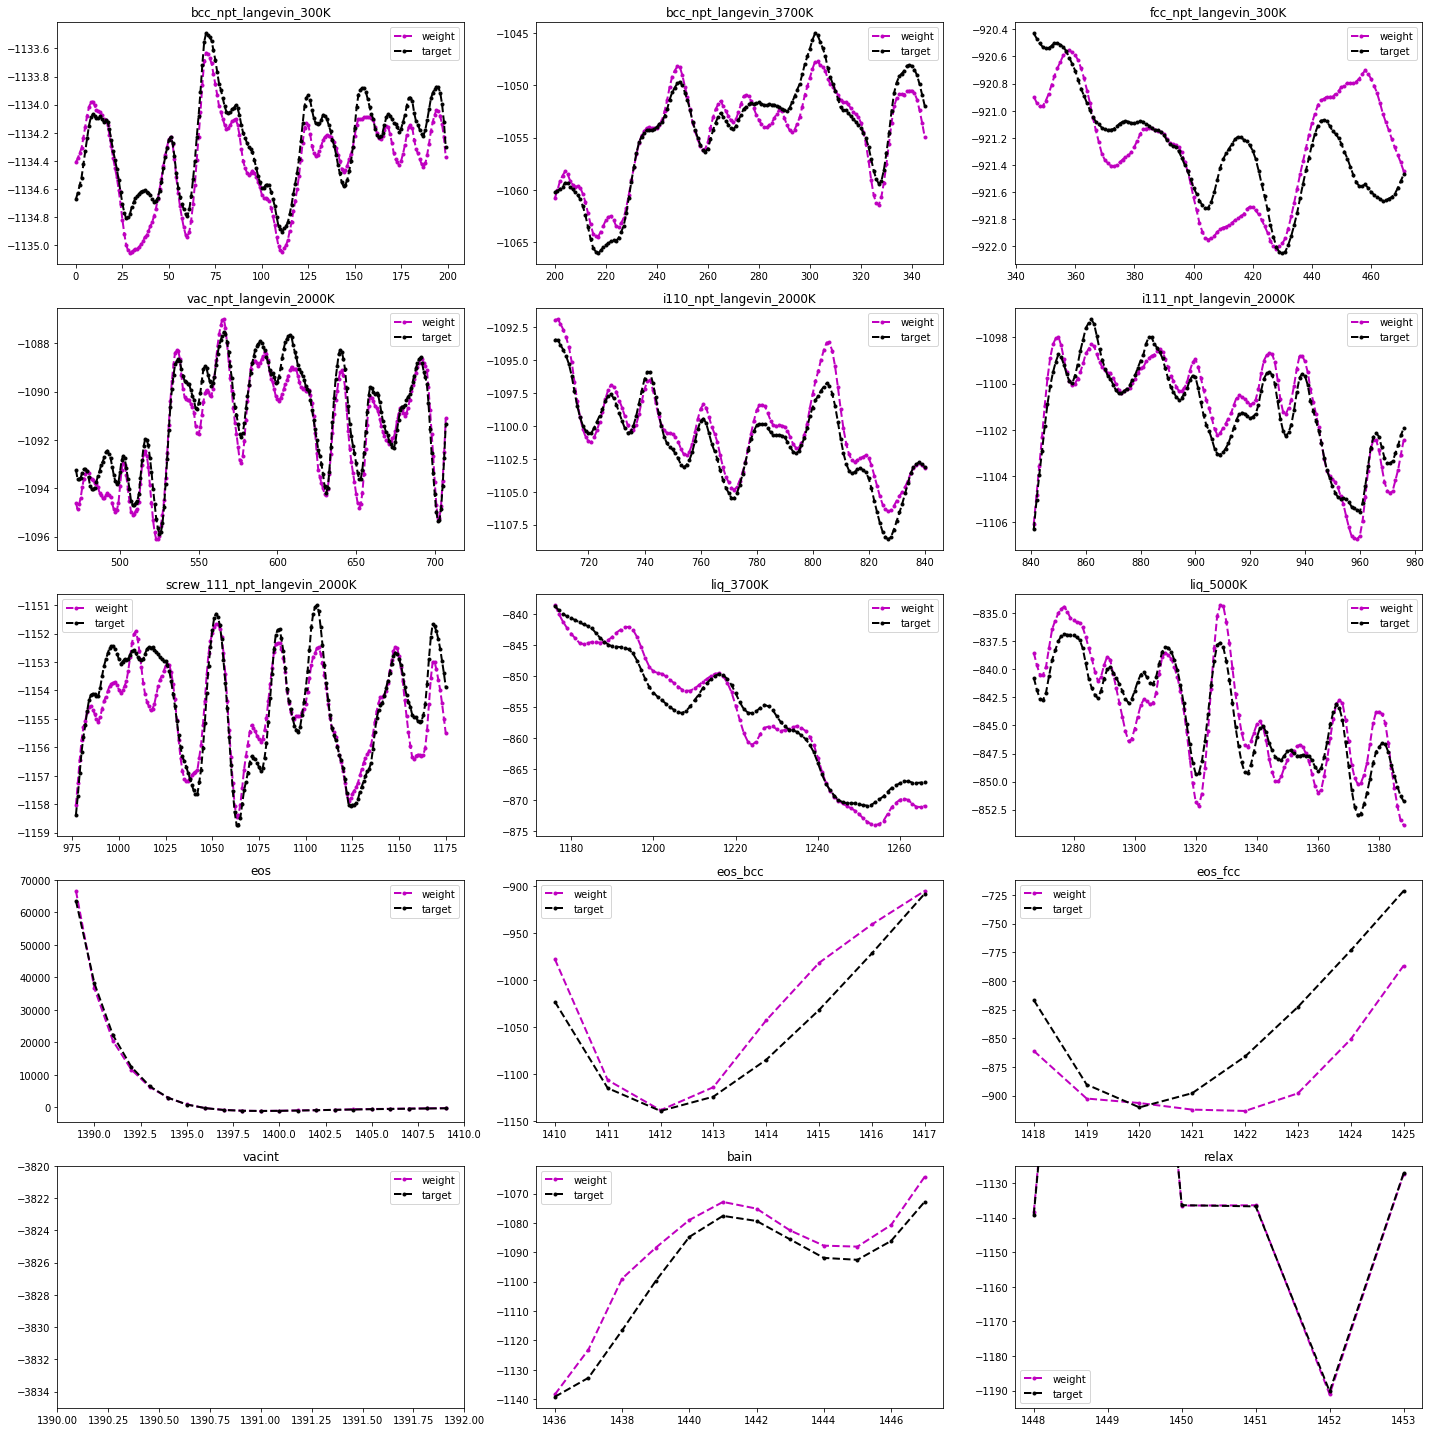

In [441]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_all)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3820)
        axes[i,j].set_xlim(1390,1392)
        
#     if trj == 'eos':
#         axes[i,j].set_ylim(-1400, -800)
#         axes[i,j].set_xlim(1395,1405)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [504]:
p_knots = np.array(pair_knots)+0.4
p_knots

array([1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45,
       2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55,
       3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65,
       4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65])

In [505]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [506]:
M = _bspline_coeffs_to_tpf(43)

In [507]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[2:]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.22824426e+03  3.54009480e+03  2.91119261e+03  2.34153772e+03
  1.83113026e+03  1.37997039e+03  9.88058321e+02  6.55394274e+02
  3.81978459e+02  1.67811053e+02  1.24862009e+01 -8.79627304e+01
 -1.43545176e+02 -1.67016514e+02 -1.68316234e+02 -1.58859588e+02
 -1.52245978e+02 -1.41522891e+02 -1.31799084e+02 -1.24427156e+02
 -1.07866113e+02 -8.29740112e+01 -6.06836589e+01 -4.81849563e+01
 -4.36744378e+01 -3.91472388e+01 -3.22134949e+01 -2.58537638e+01
 -2.26912671e+01 -2.12961404e+01 -2.06873517e+01 -1.86526528e+01
 -1.45559864e+01 -1.10689543e+01 -8.78888460e+00 -5.32464713e+00
 -1.32322585e+00  9.00599115e-01  1.19455876e+00  1.38108240e+00
 -4.40635093e-01 -1.37195754e+00 -1.22719835e+00]
[ 4.22824426e+03 -1.33728823e+04  1.41202790e+04 -4.97564098e+03
  9.10758972e-05  5.38825989e-05  3.86238098e-05  5.24520874e-06
 -2.62260437e-06 -3.64780426e-05 -4.06030059e-01 -3.56078100e+00
 -6.04279995e+00 -2.74594337e+00  2.81588787e+00 -1.47576168e+00
 -2.18415010e+00  2.05519152e+01 -1.2061

In [508]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
len(tpf_coeff), len(p_knot)

(47, 47)

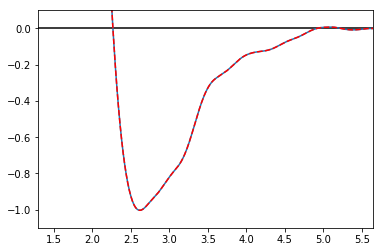

In [517]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[2:], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [513]:
tpf_coeff

array([ 4.22824426e+03, -1.33728823e+04,  1.41202790e+04, -4.97564098e+03,
        9.10758972e-05,  5.38825989e-05,  3.86238098e-05,  5.24520874e-06,
       -2.62260437e-06, -3.64780426e-05, -4.06030059e-01, -3.56078100e+00,
       -6.04279995e+00, -2.74594337e+00,  2.81588787e+00, -1.47576168e+00,
       -2.18415010e+00,  2.05519152e+01, -1.20612704e+01,  3.75615722e+00,
        1.28935941e+01, -1.23990495e+01, -1.00747538e+01,  3.74290898e+00,
        8.99336571e+00,  6.20139912e+00, -5.61500046e+00, -5.37042186e+00,
        3.57335970e-01,  4.05308592e+00, -4.48832229e-01,  1.23121627e+00,
       -1.57619130e+00, -3.30765875e+00,  2.07427372e+00,  2.98845802e+00,
       -3.03811395e+00, -1.66779622e+00,  2.16251113e+00,  1.97469831e+00,
       -3.72323444e+00,  4.79944132e+00, -2.71294960e+00, -1.79329082e-01,
       -2.31599501e+00,  3.53683585e+00, -1.22719835e+00])

In [516]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))

print('edens') 
for c, k in zip([1.0], [5.25]):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
        
print('embed')
#print(-4.42166597e-01,  1.12818607e-04)
print(-4.49779872e-01,  1.09664665e-04)

pair
+4228.2442627d0*(1.05d0 - r)**3*H(1.05d0 - r)
-13372.8822546d0*(1.15d0 - r)**3*H(1.15d0 - r)
+14120.2789984d0*(1.25d0 - r)**3*H(1.25d0 - r)
-4975.64097977d0*(1.35d0 - r)**3*H(1.35d0 - r)
+9.10758972168e-05d0*(1.45d0 - r)**3*H(1.45d0 - r)
+5.3882598877e-05d0*(1.55d0 - r)**3*H(1.55d0 - r)
+3.86238098145e-05d0*(1.65d0 - r)**3*H(1.65d0 - r)
+5.24520874023e-06d0*(1.75d0 - r)**3*H(1.75d0 - r)
-2.62260437012e-06d0*(1.85d0 - r)**3*H(1.85d0 - r)
-3.64780426025e-05d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.406030058861d0*(2.05d0 - r)**3*H(2.05d0 - r)
-3.56078100204d0*(2.15d0 - r)**3*H(2.15d0 - r)
-6.04279994965d0*(2.25d0 - r)**3*H(2.25d0 - r)
-2.74594336748d0*(2.35d0 - r)**3*H(2.35d0 - r)
+2.8158878684d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.4757616818d0*(2.55d0 - r)**3*H(2.55d0 - r)
-2.18415009975d0*(2.65d0 - r)**3*H(2.65d0 - r)
+20.5519151688d0*(2.75d0 - r)**3*H(2.75d0 - r)
-12.061270386d0*(2.85d0 - r)**3*H(2.85d0 - r)
+3.75615721941d0*(2.95d0 - r)**3*H(2.95d0 - r)
+12.893594116d0*(3.05d0 - r)**3*H(3

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01